In [1]:
%pylab inline

from scipy import stats
from matplotlib import collections

from IPython.display import Audio
from IPython.display import Image
from IPython.core.display import HTML

from helper import nice_spines

Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_styles():
    with open('custom.css', 'r') as fobj:
        css_style = fobj.read()
        
    return HTML(css_style)

set_styles()

In [3]:
from apollon.interactive import *

In [5]:
axis_kwargs = {'fontsize':13}

In [6]:
x = poisson(10, 300)

In [7]:
y = concatenate((poisson(11, 150), poisson(19, 150)))
shuffle(y)

# 1. Basic Idea

# 2. Hidden Markov Model

## 2.1 Introduction

### 2.1.1 A simple example

Consider a the following time series $x$ of 300 elements:

[ 9  4 11 12 12 13  8  7 12 12  6  2  5  9  6  6  9 10  8  7 11  9  9  8  7
 11  9  8 10  6  8  8 17 15 13 15  9 16  8 13 14 13  9  9  7  7  9 11  6 10
  6 10 14  7  6  7 12 15 10  7 15 10  6  8 11  6 11  7  7  9 12  7 14  8  7
 17  7  7 15  7  9  7  7 11 11 12  9 13  6 13  9 13 12  8 11  6 12  5  7  9
  8 10 13  7  9  9  5  7  9 13  7 11 15 11 10 11  7 11 12 13  5 11 11 10 10
  6 13  7 12  7  6 11  5 13 20 10  7 12 17 13  5  6 17  4 14  9  9  3  9  6
  8  9 15  7 13 11  9  6 14  5 13  3 10  8  8  7 18 13  6  9  4  9  8  8 12
 12  9  6  9  9 17  8 11 11 14 15  7  9 12 10 10 11  7 13  6 12 12 10  7 15
 13 12 12 15  9 10  9 16  9 12  9  8 11 12 11 13 15  8  8  4 14 13  7 10 14
 11 12 11  8 10 12 11 16 10  9 11 13 12  6  6  8  7  7 10  7 13  8 13 13  9
 13 10  5  8 10  5 13 13 11  5 13  8 14  7 11 12 13 10  9  9  2 11  9  5 14
 11  8 10  7 11  5 11 20 10 17  9 12 13  8 13 11  8  6  8 12  5  6  9 15 10]


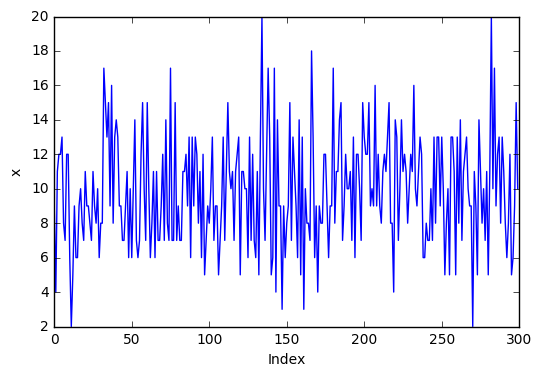

In [8]:
print(x)
plot(x);
xlabel('Index');
ylabel('x');

The first question in evey time series analysis task adresses the origin of the data. In order reproduce "similar" time series or forecast the next value of a given time series, we need to know how the data was originally created. 

A common way to tackle the problem is to conceive the time series as a random experiment. Each element $x_t, t\in [0, \infty[$ is a realization of a random variable $X_t$, such that

$$X_0=x_0, X_1=x_1, \dots, X_t=x_t, \dots, X_n=x_n.$$

We assume that all $X_t$ obey the same distribution. 
Our time series is then **one possible realization** of a the stochastic process $\{X_t\}, t \in [0, \infty[$. 

To generate a time series, consider each random variable as dice. You pick up the first one, throw it, and place it one the first position of your results. Then you would proceed with the next dice analogously. 


We can easily generalize from the expectation of the single random variables to the expectation of the whole process:
$$E(\sum_{t=0}^n X_t) = \sum_{t=0}^n E(X_t).$$

Thus, each $X_t$ has the same expectation as the whole time series. Consider now the distribution of $x$ in the histogram below.

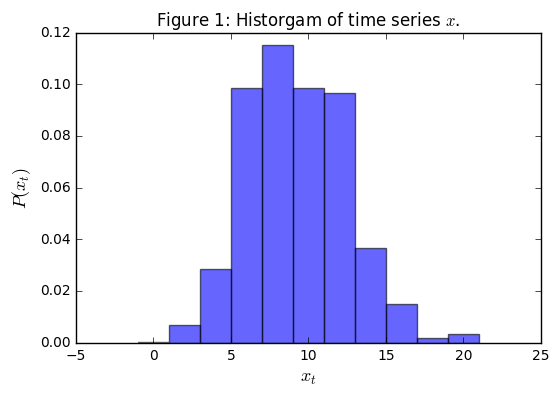

In [9]:
hx = hist(x, bins=range(0,24,2),normed=True, align='left', alpha=.6);
title('Figure 1: Historgam of time series $x$.')
xlabel(u'$x_t$', **axis_kwargs)
ylabel(u'$P(x_t)$', **axis_kwargs)

In Figure 1, we can see, that $x$ is unimodal and its sample mean and variance are around 10. The precise values are $\overline{x} = 9.95$ and $s^2 = 8.57$. Additionally, the time series consists of strictly positive integers. 
Thus, the Poisson distribution suggests itself as a model for the observed data. 
We, therefore, assume: 

$$
X_t \sim Poisson_k(\lambda).
$$

The distribution function of the Poisson is given by

$$
P_{\lambda}(k) = \frac{\lambda^k}{k!} e^{-\lambda}, k \in [0, \infty[.
$$


Since the parameter $\lambda$ represents the mean and the variance of a Poisson distribution, the sample mean $\overline{x}$ is naturally an intuitive estimator of $\lambda$. Figure 2 shows a histogram of $x$ and a fitted Poisson distribution with $\lambda = \overline{x}$.

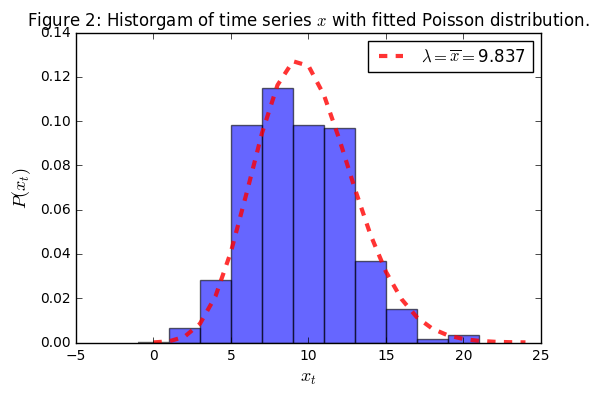

In [10]:
hx = hist(x, bins=range(0,24,2), normed=True, align='left', alpha=.6);
t = arange(0, 25)
mu = mean(x)
plot(t, stats.poisson.pmf(t, mu), 'r--', lw=3, alpha=.8, label='$\lambda=\overline{x}=$'+'{}'.format(round(mu, 3)))
title('Figure 2: Historgam of time series $x$ with fitted Poisson distribution.')
xlabel(u'$x_t$', **axis_kwargs)
ylabel(u'$P(x_t)$', **axis_kwargs)
legend()

We can also estimate $\lambda$ analytically by estimating the **likelihood** of our model. Suppose $p(\boldsymbol{x}; \boldsymbol{\theta})$ to be a probability function of the data $\boldsymbol{x}$, governed by a set distribution parameters $\boldsymbol{\theta}$. The likelihood $L$ represents the joint probability density of the data given the model parameters under the assumption that each element of $\boldsymbol{x}$ was drawn independently.
$$
L(\boldsymbol{\theta} | \boldsymbol{x}) = p(\boldsymbol{x} | \boldsymbol{\theta}) = \prod_i^N P(x_i | \boldsymbol{\theta}).
$$


The likelihood, therefore, is a function of the variable *model parameters* regarding an *observed*, and hence fixed, *data set*. For each set of parameters it yields the probability of the data, given that specific set. 
The idea is now to find that one set of parameters, that maximizes the probability of the data. That means, we choose that one set of parameters, that *most likely* generated our data.

Since the Poisson distribution has only one parameter $\lambda$. The parameter $\lambda^*$ that maximizes the Likelihood is given by:

$$
\lambda^* = \underset{j}{\text{argmax}} \ L(\lambda_j | \mathbf{x},)
$$

which expands through insertion of the distribution function to:

$$
\lambda^* = \underset{j}{\text{argmax}} \ \prod_i^N \frac{\lambda_j^{x_i}}{x_i!}e^{-\lambda_j}.
$$

In practice the maximization causes numerical instability. Since each value $P(x_i|\lambda)$ is a probability and, thus an element of $[0, 1]$, the product decreases fastly. To overcome this issue, we exploit the fact, that
$\log(xy) = \log(x) + \log(y).$ 
Instead of maximizing the likelihood, we minimize the negative logarithm of the likelihood:

$$
\lambda^* = \underset{j}{\text{argmin}} \ -\sum_i^N \log(\frac{\lambda_j^{x_i}}{x_i!}e^{-\lambda_j})
$$

The other reason for taking the logarithm is that we can easily differentiate the resulting function in order to solve the problem analytically. To this end, we just have to take the first derivative of the negative log likelihood and find its root. This way we can also proove that $\overline{x}$ is indeed the maximum likelihood estimator $\lambda^*$. Figure 3 illustrates the numerical and the analytical approach.

In [11]:
lambda_range = arange(1, 30, .1)

# compute the negative log likelihood ...
likelihood = [-log(stats.poisson.pmf(x, lambda_)).sum() for lambda_ in lambda_range]

# ... and find the root numerically
min_like = min(likelihood)
argmin_like = argmin(likelihood)
lam_min = lambda_range[argmin_like]

# compute the first derivative of the negative log likelihood
dL = array([(- (lambda_ - x) / lambda_).sum() for lambda_ in lambda_range])

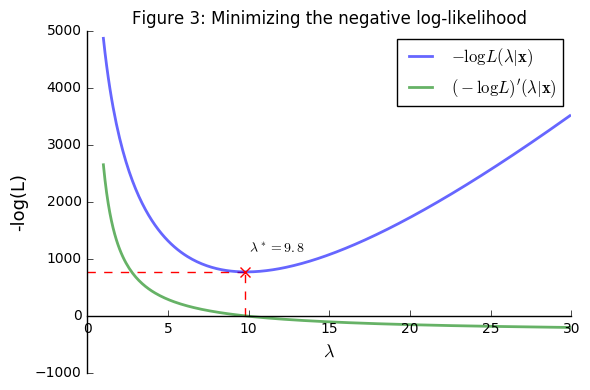

In [12]:
nice_spines()
plot(lambda_range, likelihood, lw=2, alpha=.6, label='$- \log L(\lambda|\mathbf{x})$')
plot(lambda_range, dL, lw=2, alpha=.6, label="$(- \log L)'(\lambda|\mathbf{x})$")
hlines(min_like, 0, lam_min, linestyles='dashed', colors='r', lw=1)
vlines(lam_min, 0, min_like, linestyles='dashed', colors='r', lw=1)
plot(lam_min, min_like, 'xr', markeredgewidth=1, markersize=7)
annotate(s='$\lambda^*={}$'.format(round(lam_min, 2)), xy=(lam_min, min_like), xytext=(10, 1100))
title('Figure 3: Minimizing the negative log-likelihood')
xlabel('$\lambda$', **axis_kwargs)
ylabel('-log(L)', **axis_kwargs)
legend()
tight_layout()

### 2.1.2 A more complex example

Consider now the time series $y$ and its histogram:

[26 14  9  7 13 26 16 15 21 22 23 19 12 17 16 13 10 17  6 25 16 13 21 23 22
 22 15 19 18 14 15 10 22 20 14 17 10 11 22 10 17 15  6  9 15 18 18 19  9 21
 24 17 16  7 18 11 11 24 18 11 21 20 13  8 12 10 14 20 18 10 11  6  7 20 18
 17 20 11 12 10 21 12 12 21 20 13 19  8 16 21 14 12 12 11 17 20 16  9  9 13
 14  9  9  7 17  5 12  5 21 21 14 19 20 13 13  9 12 24 18 22 15 18 11  9  5
 11 15 11 23 16 12 13 24 18 10 10 12 12  9 10 20  6 13  8 20 19 21 12  6 18
 11 16  9 27 17 24 14 12  9 22 14 18 11  7 18 24  8 23 19 10 18 18  5 22 10
 15 14 20  4 20 18  9 11 21 21 15  8  9 23 13 11 12 13 20  8 11 17  7 27 10
  6  8  9 18 16 16 18 11 24  9  7 11  4 10  6 18  5 15 20 21 18  7 10 10 21
 17 20 11 19 11 18 26  8 16 12 11 21 10  8 14 18 15 20  5 18 21 10  9 23 14
  7 32 10 22 18 12 13 13 25 15 10 24 14 15 16  7  9 15 14 10 15 13  9 14 13
 18  3  9 12 18 20 15 11 19 29 22  9 14  8 21 11 17 23 18 13 10 13 18 13 18]


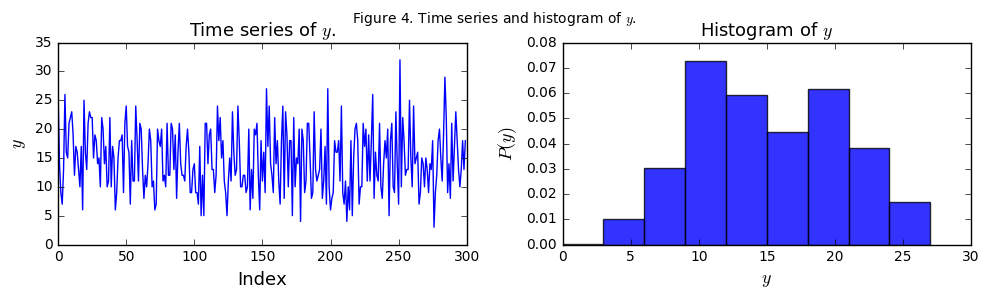

In [13]:
print(y)
fig, (ax1, ax2) = subplots(1, 2, figsize=(10, 3));
fig.suptitle('Figure 4. Time series and histogram of $y$.')
ax1.plot(y);
ax1.set_title('Time series of $y$.', **axis_kwargs);
ax1.set_xlabel('Index', **axis_kwargs);
ax1.set_ylabel('$y$', **axis_kwargs);
ax2.hist(y, bins=range(0, 30, 3), alpha=.8, normed=True, align='mid');
ax2.set_title('Histogram of $y$', **axis_kwargs);
ax2.set_xlabel('$y$', **axis_kwargs);
ax2.set_ylabel('$P(y)$', **axis_kwargs);
tight_layout()

It is evident form the above figures, that $y$ does not obey a Poisson distribtion. The shape of the histogram is totally different form what we would expect from a Poisson distributed random variable. Nevertheless, $y$ seems the represent some sort of counts, too, since all elements of $y$ are positive integers. Thus, the *kind of data*  suggests a Poisson distribution. but the *shape of data* does not. In such cases it is convenient to model the data set as a mixture of several Poisson distributions, each with their own parameter $\lambda_i$. 

Assume the above time series $y$ was generated by a random process $Y$, which obeys a mixture of two Poisson distributions with parameters $\lambda_1$ and $\lambda_2$. One single observation is created by choosing one of the two distributions and then drawing an sample from it. The next sample is generated in the same. Note that we sill assume both smpling processes to be independent. 

To model this, we first need to find an appropriate expression for "choosing the distribution". Then we have to insert this expression into the above formalism.

We call the random variable $C$ with the discrete distribution

$$
C = \begin{cases} 
    1 \text{ with probability }\delta_1 \\
    2 \text{ with probability } \delta_2 = 1 - \delta_1
\end{cases}
$$

**parameter process**, with $\delta_i$ representing the probability of choosing the component distribution $i$.
With the law of total probability $P\left(X=x\right) = \sum_{i=1}^n P\left(X=x | C=i\right)P\left(C=i\right)$ the distribution function of $Y$ is given by

$$
P\left(k\right) = \delta_1 P_{\lambda_1}(k) + \delta_2 P_{\lambda_2}(k) = \sum_{i=1}^2 \delta_i P_{\lambda_i}(k)
$$

We need to estimate the parameters: $\lambda_i$ and $\delta_{i-1}$. $\delta_n$ is given by $\delta_n = 1 - \sum_{i=1}^{n-1} \delta_i$. The likelihood is, in general, given by

$$
L(\boldsymbol{\lambda}, \boldsymbol{\delta} | \mathbf{x}) = \prod_{j=1}^{n} \sum_{i=1}^m \delta_i P_{\lambda_i}(x_j)
$$

In this example with only two component distributions, the above expression simplifies to:

$$
L(\lambda_1, \lambda_2, \delta_1 | \mathbf{x}) = \prod_{i=1}^n 
\left( \delta_1 \frac{\lambda_1^{x_i}}{x_i!} e^{-\lambda_1} +
(1-\delta_1) \frac{\lambda_2^{x_i}}{x_i!} e^{-\lambda_2} \right)
$$

Here we have no chance to solve the problem analytically, since calculation of the derivative is way to complex. Hence, the numerical approach is the only option. But this approach is also problematic, since the likelihood is a function of three parameters and thus represents a 3-d hyperplane.

Figure 5 illustrates the negative log likelihood for fixed $\boldsymbol{\delta} = (.5, .5)$, the values $y$ was generated with.

In [14]:
delta = array([.5, .5])

ar = arange(1, 50, 1)
br = arange(1, 50, 1)
out = zeros((len(ar), len(br)))
for i, a in enumerate(ar):
    for j, b in enumerate(br):
        pp = array([stats.poisson.pmf(y, lam) for lam in (a, b)])
        out[i,j] = -log((pp.T * delta).sum(axis=1)).sum()
        
ae_idx, be_idx  = unravel_index(argmin(out), out.shape)
est_a = ar[ae_idx]
est_b = br[be_idx]

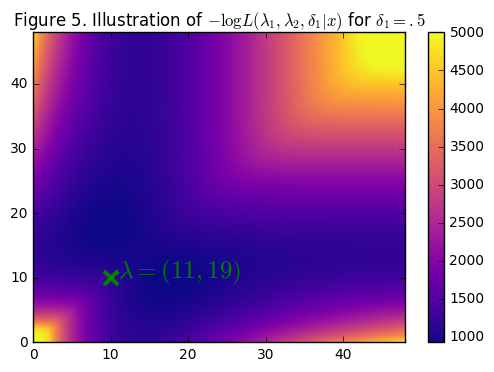

In [15]:
title('Figure 5. Illustration of $-\log L(\lambda_1, \lambda_2, \delta_1 | x)$ for $\delta_1=.5$')
imshow(out, origin='lower', cmap='plasma', aspect='auto', vmax=5000)
plot(ae_idx, ae_idx, 'xg', markeredgewidth=3, markersize=10)
vals = round(est_a, 2), round(est_b, 2)
annotate(s='$\lambda=({}, {})$'.format(*vals), xytext=(11,10), xy=(ae_idx, be_idx), fontsize=18, color='g')
axis([0, out.shape[0]-1, 0, out.shape[1]-1]);
colorbar()

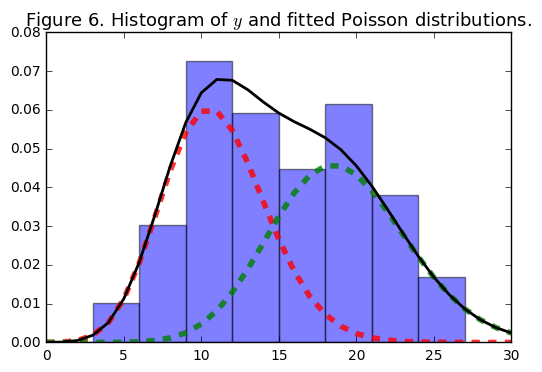

In [16]:
hist(y, bins=range(0, 30, 3), alpha=.5, normed=True, align='mid');
title('Figure 6. Histogram of $y$ and fitted Poisson distributions.', **axis_kwargs);
t = arange(0,31, 1)
pa = stats.poisson.pmf(t, est_a)*delta[0]
pb = stats.poisson.pmf(t, est_b)*delta[1]
plot(t, pa, 'r--', lw=4, alpha=.8)
plot(t, pb, 'g--', lw=4, alpha=.8)
plot(t, pa+pb, 'k', lw=2)

### 2.1.1 Basic idea of HMM

A straightforeward example of such a Poisson Mixture Model (PMM) is the number of packs of cigaretts bought by smoking and non-smoking customers in a given store during a specified period of time. Assume that there is a probability of .8 that the next customer who walks in is a smoker. Hence, the probability for a non-smoker is .2 and it holds that $\boldsymbol{\delta} = (.8, .2)$. On average, a smoker buys more cigarettes than a non-smoker, thus, e.g., $\boldsymbol{\lambda} = (5, 1)$. In such a way a PMM could easily model the illustrated distribution.

Imagine we would need to model the food requirements of an experimental mouse. We monitor the amount of food in its trough every hour and recognize that at destinct time points the mouse consumes significantly more food that during the rest of the time. We conclude that the mouse's eating behaviour must by governed by an unknow process. We further observe that the mouse needs a long time an average amount of food. But then it suddenly eats practically nothing and just after that a huge amount. The it returns to its average behaviour for long period.

The great difference between the cigarrets and the mouse example is that the observations in the latter are not independent. That means that the states of the unobservable process, depend on each other. In this example the dependence states that on a state, which tiggers an average eating behavior, follows in most cases the same state again. In just a few other cases the underlying state changes to one that triggers an "abnormal" eating behavior. Thus, there is a high probability of observing average eating behavior after we have already observed just that behaviour. Hence, there is just a small probability to oberserve an abnormal behaviour, after we have seen an normal behaviour. This is the basic idea of the Hidden Markov Model.

Let's set this into formulas! We know the mouse eats an average amount, most of the time, sometimes practically nothing, and some other times huge load. We can easily model this with three Poisson distributions and guess their parameters, in order to have something to start with:

$$
\boldsymbol{\lambda} = \begin{cases}
    \lambda_1 = 2, & \text{eats a littel} \\
    \lambda_2 = 6, & \text{average} \\
    \lambda_3 = 11, & \text{eats a lot}
\end{cases}
$$

We now need to find a convenient expression for the parameters process. Commonly the probabilities to change from state $s_1$ to $s_n$ are denoted in a **transition probability matrix** $\boldsymbol{\Gamma}$. The entries in this matrix represent the probabilities to change from state to state. Let $i, j \in [1, m]$, represent the rows, and cols of the matrix and let $m$ be the number of give states. Then entry in $i$th row and $j$ col $\gamma_{ij}$ denotes the probability to translate from state $s_i$ to $s_j$. An initial guess of $\boldsymbol{\Gamma}$ given the above example could look like:

$$
\boldsymbol{\Gamma} = \begin{pmatrix}
     0.5 & .3 & .2 \\
     0.1 & .4 & .5 \\
     0.5 & 0. & .5
\end{pmatrix}
$$

## 2.2 HMM - Definition and properties

Let $\{ C_t \ : \ t \in \mathbb{N} \}$ be a stochastic process. ${C_t}$ is called a **Markov Chain** iff it satisfies the Markov property

$$
\text{Pr}\left(C_t \ | \ \boldsymbol{C}^{(t-1)}\right) = \text{Pr}\left(C_t \ | \ C_{t-1}\right),
$$

where $C^{(t-1)}$ referrs to the history of $C$ until $t-1$.

The stochastic process $\{X_t \ : \ t \in \mathbb{N} \}$ is called **Hidden Markov Model** iff


$$
\text{Pr} \left( X_t \ | \ \boldsymbol{X}^{(t-1)}, \boldsymbol{C}^{(t)} \right) = \text{Pr}\left(X_t \ | \ C_{t}\right).
$$

The above definition states that a Hidden Markov Model is a **dependent mixture**, which consits of two components:

1. an unobservable *parameter process* ${C_t}$, which is a Markov Chain, and
2. a *state-dependent process* ${X_t}$.

As well as in section 2.1.2, ${C_t}$ here represents the random selection of a distribution parameter, hence parameter process. Each outcome of $C$ is called a state $s$, with $s \in S$. The transition from state $C_{t-1} = s_i$ to state $C_{t} =s_j$ is constrained is such a way that the outcome of $C_t$ only depends on the outcome of $C_{t-1}$. The outcome of $C_t$ is a parameter to the process $X_t$ and assumed to be not observed. 

The outcome of the distribution $X_t$ depends only on the current outcome of the underlying Markov Chain $C_t$. It does not depent on previous states and it does not depend on previous observations.

In [17]:
### MC img

## Component distributions

Likelihood

## 2.3 Common applications

### 2.3.1 Evaluation

The evalutation problem deals with calculating $\text{Pr}(\boldsymbol{O}\ |\ \boldsymbol{\theta})$, the probability of a sequence of observations given a set of model parameters. This is, in fact, the computiation of the likelihood of the model.

### 2.3.2 Estimation

In the estimation problem we seek to estimate the "best" hidden state for each observation. This is also known as *decoding*, since we want to decode the observations into states. There are two slightly different ideas of decoding:

In **local decoding** we estimate the most likely state for each observation separately at each time step. Thus, maximize the conditional probability for each $t$ regardless of the big picture, hence, it is a local way of decoding.

In **global decoding** we incorporate the contex in our calculation and, thus, maximize the conditional probability regarding the most likely sequence of states.

### 2.3.3 Training

The training problem copes with finding the best parameter vector $\boldsymbol{\theta}$ by maximizing the likelihood. This is often referred to as training or learning, since the model gets traind (or learns) how to be a good generator for the given data. Another common term for this procedure is *fitting*, since the model seeks to be a best fit distribution of the data set.
Model fitting is the most complex of three mentioned problems.

## 2.4 Model fitting

### 2.4.1 MLLK vs. EM

### 2.4.2 Initial guess

### 2.4.3 Results

$\lambda, \Gamma, \delta$

## 2.5 Model Selection

## 2.6 Example

### 2.6.1 Simple artificial example

In [18]:
# sample data from two poisson distributions, 
# 40 samples from the first, 20 from the second, ... 4 times

# poisson means
mu = [20, 35]

# size of sample
n = 40 

data = concatenate([poisson(m, n) for i in range(4) for m in mu])

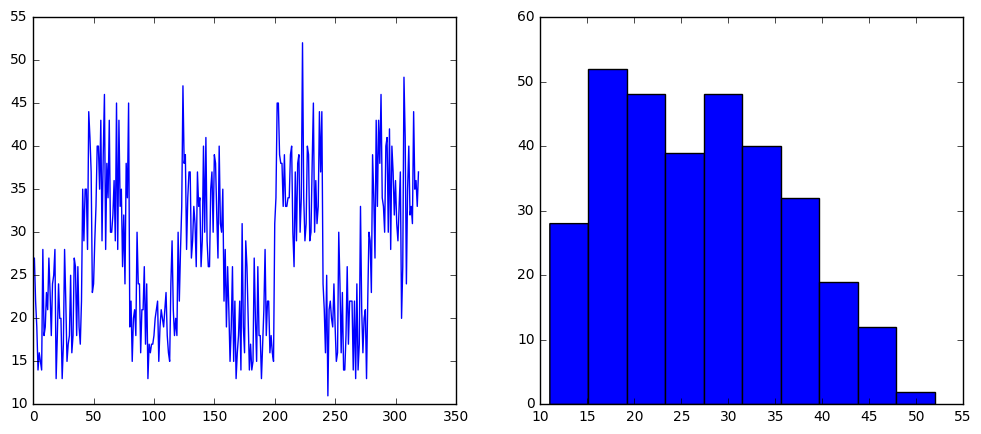

In [19]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(12, 5))
ax1.plot(data);
ax2.hist(data);

In [20]:
# Initialization
mod = PoissonHMM(data, 2)

In [21]:
# Training
mod.train_MLLK()

Optimization terminated successfully.
         Current function value: 1009.284814
         Iterations: 3
         Function evaluations: 151


True

In [22]:
mod.nice()

Lambda
[ 20.09  34.56]

Delta
[ 0.48  0.52]

Gamma
[[ 0.98  0.02]
 [ 0.02  0.98]]

Mllk           AIC            BIC            
1009.285       2024.57        2045.785       


In [23]:
# Estimation
vp = viterbi(mod, data)

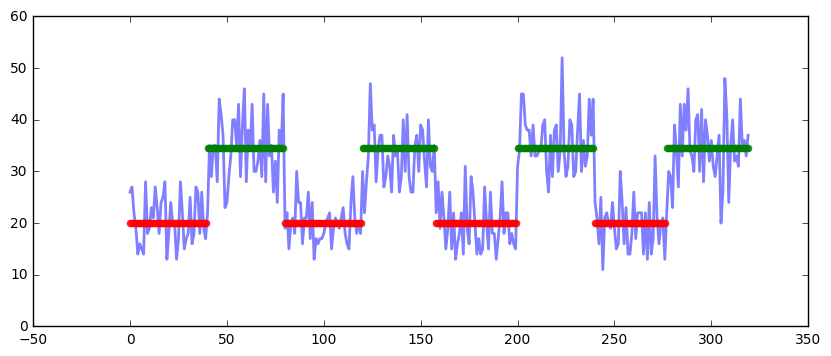

In [24]:
fig, ax = subplots(1,1, figsize=(10, 4))
ax.plot(data, zorder=-1, alpha=.5, lw=2)

x = where(vp==0)[0]
nx = len(x)
ax.scatter(x, tile(mod.lambda_[0], nx), c='r', edgecolors='r', alpha=.8)

x = where(vp==1)[0]
nx = len(x)
ax.scatter(x, tile(mod.lambda_[1], nx), c='g', edgecolors='g', alpha=.8)


### 2.6.2 Music

In [4]:
# load audio file
x = loadwav('audio/beat.wav', norm=False)

In [5]:
Audio(x, rate=x.get_sr())

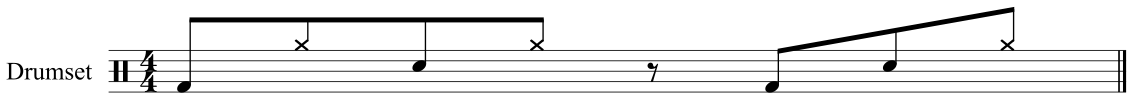

In [6]:
Image('img/beat.png')

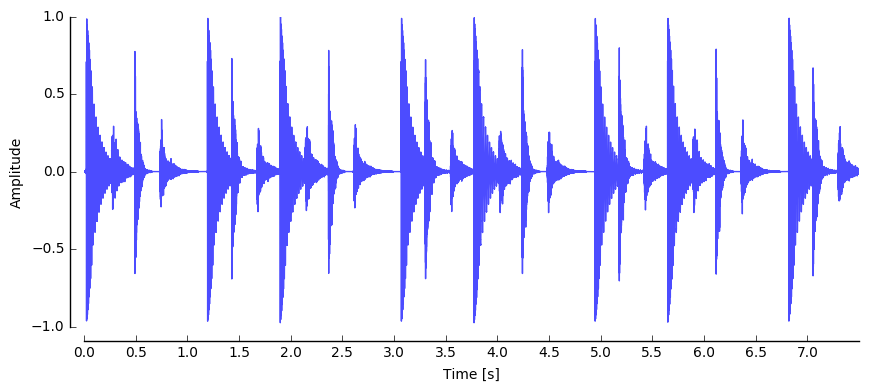

In [7]:
x.normalize()
x.plot()

In [8]:
# System flow
#
# 1. Onset detection
# 2. Feature extraction
# 3. HMM

(<matplotlib.figure.Figure at 0x108f14208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x109dbafd0>)

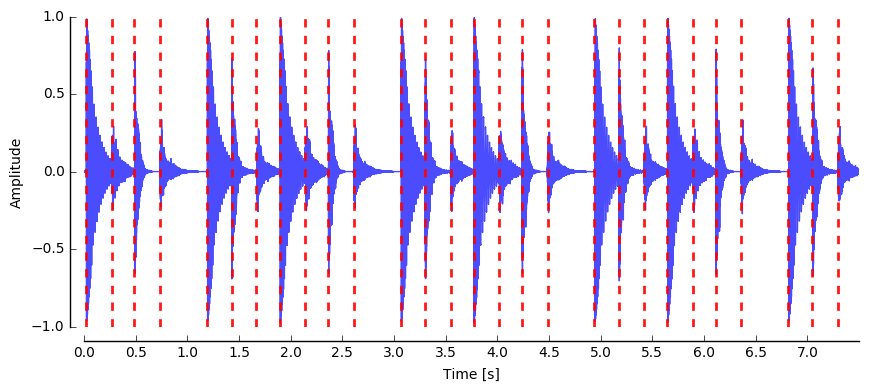

In [9]:
# onset detection
ons = onsets.detect(x)
ons.plot(x)

In [10]:
# Feature extraction
#

# only extract features at onset positions
chunks = segment.from_onsets(x, ons.odx, 2**12)

# extract spectral centroid
spc = extract.spectral_centroid(chunks, hamming, sr=chunks.get_sr())

# to int 
feat = spc.astype(int)

(<matplotlib.figure.Figure at 0x1092b1b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1092baf98>)

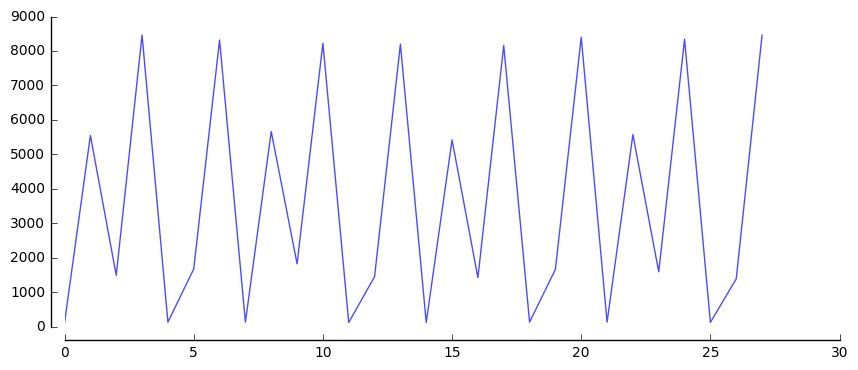

In [11]:
aplot.signal(feat)

In [12]:
# tile
feat = tile(feat, 10)

In [13]:
mod = PoissonHMM(feat, 3)
mod.train_MLLK()

Optimization terminated successfully.
         Current function value: 4478.188347
         Iterations: 4
         Function evaluations: 565


True

In [14]:
mod.nice()

Lambda
[  122.87  1560.37  8320.62]

Delta
[ 0.36  0.36  0.29]

Gamma
[[ 0.2  0.8  0. ]
 [ 0.   0.2  0.8]
 [ 1.   0.   0. ]]

Mllk           AIC            BIC            
4478.188       8962.377       8997.889       


In [15]:
vp = viterbi(mod, feat)

(<matplotlib.figure.Figure at 0x109304e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1093480b8>)

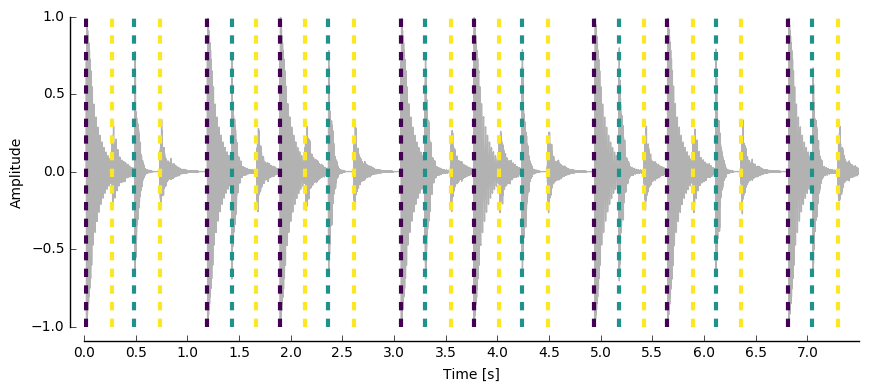

In [16]:
aplot.onset_decoding(x, ons, vp)

In [38]:
fcs = mod.lambda_
fcs = fcs.round(2)
for i in range(mod.m):
    print('State {}: f_c = {}'.format(i, fcs[i]))
print('\n')
for c,v,n  in zip(chunks, vp, range(len(chunks))):
    print('Chunk No: {}, State: {}'.format(n, v))
    display(Audio(c, rate=chunks.get_sr(), autoplay=False))

State 0: f_c = 74.25
State 1: f_c = 2294.88
State 2: f_c = 4575.99
State 3: f_c = 7779.75


Chunk No: 0, State: 0


Chunk No: 1, State: 2


Chunk No: 2, State: 1


Chunk No: 3, State: 3


Chunk No: 4, State: 0


Chunk No: 5, State: 1


Chunk No: 6, State: 3


Chunk No: 7, State: 0


Chunk No: 8, State: 2


Chunk No: 9, State: 1


Chunk No: 10, State: 3


Chunk No: 11, State: 0


Chunk No: 12, State: 1


Chunk No: 13, State: 3


Chunk No: 14, State: 0


Chunk No: 15, State: 2


Chunk No: 16, State: 1


Chunk No: 17, State: 3


Chunk No: 18, State: 0


Chunk No: 19, State: 1


Chunk No: 20, State: 3


Chunk No: 21, State: 0


Chunk No: 22, State: 2


Chunk No: 23, State: 1


Chunk No: 24, State: 3


Chunk No: 25, State: 0


Chunk No: 26, State: 1


Chunk No: 27, State: 3


## 3. Conclusion

* Model results are plausible (works!)
* Crucial parameters:
    * number of HMM states $m$ 
    * length of integration interval